In [1]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
character_directories = listdir(train_root_path)
character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))


Train: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum']
Test: ['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


### Calculate mean width and lenght from test images

In [4]:
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
num_test_images = len(test_image_names)

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//num_test_images
lenght_mean = lenght//num_test_images
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [126]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

### Show some test examples

Label:lisa_simpson, Image:567, Shape:(171, 114, 3)


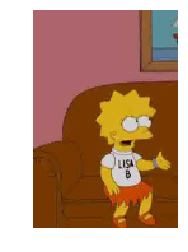

In [76]:
idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)

print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Making batches (resized)

In [191]:
def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_size):
    data = {'image':[], 'label':[]}
    character_batch_size = batch_size//len(character_directories)
    character_batch_init = batch_init//len(character_directories)
    character_batch_end = character_batch_init + character_batch_size

    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(character_batch_init, character_batch_end):
            path_file = os.path.join(path, images_list[i])
            image = imread(path_file)
            #all with the same shape
            image = imresize(image, (dim_size, dim_size))
            data['image'].append(image)
            data['label'].append(character)
    
    return data

def get_batches(num_batches, batch_size, verbose=False):
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    if verbose:
        print("Batches:{} Size:{}".format(num_batches, batch_size))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
        
    for i in range(0, num_batches):
        init = i * batch_size
        if verbose:
            print("batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
        
        yield get_batch(init, batch_size)

In [192]:
#num max of samples
num_samples = get_num_of_samples()
print("Number of samples:{}".format(num_samples))

#testing generator
batch_size = 100

for b in get_batches(10, batch_size, verbose=True):
    print("retrieved {} images".format(len(b['image'])))

Number of samples:19413
Batches:10 Size:100
batch-0 yielding images from 0 to 100...
retrieved 100 images
batch-1 yielding images from 100 to 200...
retrieved 100 images
batch-2 yielding images from 200 to 300...
retrieved 100 images
batch-3 yielding images from 300 to 400...
retrieved 100 images
batch-4 yielding images from 400 to 500...
retrieved 100 images
batch-5 yielding images from 500 to 600...
retrieved 100 images
batch-6 yielding images from 600 to 700...
retrieved 100 images
batch-7 yielding images from 700 to 800...
retrieved 100 images
batch-8 yielding images from 800 to 900...
retrieved 100 images
batch-9 yielding images from 900 to 1000...
retrieved 100 images


### Preprocessing data

In [161]:
from sklearn import preprocessing

#num characters
num_characters = len(character_directories)

#normalize
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean)/std

#one-hot encode
def one_hot(label):
    lb = preprocessing.LabelBinarizer()
    lb = lb.fit(character_directories)

    return lb.transform([label])


### Storing preprocessed batches on disk

In [236]:
import pickle

num_batches = 10
batch_size = 200

cnt_images = 0
for cnt, b in enumerate(get_batches(num_batches, batch_size)):
    data = {'image':[], 'label':[]}

    for i in range(batch_size):
        image = b['image'][i]
        label = b['label'][i]
        data['image'].append(normalize(image))
        data['label'].append(one_hot(label))
        cnt_images += 1
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    
print("Loaded {} train images and stored on disk".format(cnt_images))


Loaded 2000 train images and stored on disk


In [237]:
#testing load from file

with open('simpson_train_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print(data['image'][0])

[[[-1.04199219 -0.73107606  0.40894975]
  [-1.02126445 -0.68962057  0.45040524]
  [-0.95908122 -0.60670961  0.51258846]
  ..., 
  [-0.02633283  0.11876136  0.69913814]
  [-0.02633283  0.11876136  0.69913814]
  [-0.02633283  0.11876136  0.69913814]]

 [[-1.04199219 -0.73107606  0.40894975]
  [-1.02126445 -0.68962057  0.45040524]
  [-0.97980896 -0.62743735  0.49186072]
  ..., 
  [-0.04706057  0.09803362  0.6784104 ]
  [-0.04706057  0.09803362  0.6784104 ]
  [-0.04706057  0.09803362  0.6784104 ]]

 [[-1.04199219 -0.73107606  0.40894975]
  [-1.04199219 -0.68962057  0.42967749]
  [-1.0005367  -0.60670961  0.49186072]
  ..., 
  [-0.02633283  0.11876136  0.71986588]
  [-0.02633283  0.11876136  0.71986588]
  [-0.02633283  0.11876136  0.71986588]]

 ..., 
 [[-0.15069928  0.11876136 -0.3579767 ]
  [ 0.61622717  0.76132136  0.61622717]
  [ 0.90641556  1.03078201  1.3209704 ]
  ..., 
  [ 0.47113298 -0.02633283 -2.11983477]
  [-0.12997154 -0.48234315 -1.24926961]
  [-0.02633283 -0.29579348  0.01512

### Building the Network

In [29]:
import tensorflow as tf

#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    
    #pooling
    conv = tf.nn.max_pool(conv, pool_shape, stride_shape, padding='SAME')
    
    return conv

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [30]:
##building the network
#remove previous weights, bias, etc
tf.reset_default_graph()

#data
X = tf.placeholder(tf.float32, (None,) + images_norm.shape[1:])
y = tf.placeholder(tf.float32, (None,) + labels_one_hot.shape[1:])

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 16)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = labels_one_hot.shape[1:]

logits = classifier(flatten, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

[None, 150, 150, 3]
[None, 38, 38, 16]
[None, 10, 10, 32]
[None, 3, 3, 64]
Inputs shape: [150, 150, 3]
Flatten shape: 576
Outputs shape: 20


In [31]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [69]:
#obtaining batch with random data from dataset
def get_batches(x, y, batch_size):
    #idx = np.random.randint(x.shape[0], size=size)
    #x_batch, y_batch = x[idx,:], y[idx,:]
    
    sections = len(x)//batch_size
    return np.array_split(x, sections, axis=0), np.array_split(y, sections, axis=0)

In [77]:
##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

#train and validation
#for i in range(images_norm.shape[0]):
#    r = random.random()
#    if (r < 0.8):
#        x_train.append(images_norm[i])
#        y_train.append(labels_one_hot[i])
#    else:
#        x_val.append(images_norm[i])
#        y_val.append(labels_one_hot[i])

#x_train = np.array(x_train)
#y_train = np.array(y_train)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images_train_norm, labels_train_one_hot, test_size=0.2, random_state=42)

##
epochs = 20
batch_size = 128

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    x_batches, y_batches = get_batches(x_train, y_train, batch_size)
    for i in range(len(x_batches)):
        feed_dict = {X:x_batches[i], y:y_batches[i]}
        sess.run(optimizer, feed_dict)
        loss, acc = sess.run([cost, accuracy], feed_dict)
        print("Epoch:{} batch:{} Loss:{:.4f} Accuracy:{:.4f}".format(e, i, loss, acc))

Epoch:0 batch:0 Loss:6.4725 Accuracy:0.0985
Epoch:0 batch:1 Loss:5.2042 Accuracy:0.0303
Epoch:0 batch:2 Loss:4.3529 Accuracy:0.0682
Epoch:0 batch:3 Loss:4.6337 Accuracy:0.0606
Epoch:0 batch:4 Loss:4.7195 Accuracy:0.0379
Epoch:0 batch:5 Loss:4.2821 Accuracy:0.0530
Epoch:1 batch:0 Loss:3.9561 Accuracy:0.0455
Epoch:1 batch:1 Loss:4.3015 Accuracy:0.0682
Epoch:1 batch:2 Loss:3.9093 Accuracy:0.0455
Epoch:1 batch:3 Loss:4.0618 Accuracy:0.0682
Epoch:1 batch:4 Loss:3.6768 Accuracy:0.0606
Epoch:1 batch:5 Loss:3.6311 Accuracy:0.0758
Epoch:2 batch:0 Loss:3.3011 Accuracy:0.0833
Epoch:2 batch:1 Loss:3.4146 Accuracy:0.0758
Epoch:2 batch:2 Loss:3.2662 Accuracy:0.0606
Epoch:2 batch:3 Loss:3.3737 Accuracy:0.0682
Epoch:2 batch:4 Loss:3.3274 Accuracy:0.0303
Epoch:2 batch:5 Loss:3.1828 Accuracy:0.0833
Epoch:3 batch:0 Loss:3.0207 Accuracy:0.0682
Epoch:3 batch:1 Loss:3.1368 Accuracy:0.0530
Epoch:3 batch:2 Loss:3.0038 Accuracy:0.0909
Epoch:3 batch:3 Loss:3.0221 Accuracy:0.0909
Epoch:3 batch:4 Loss:3.1457 Accu

Label:['nelson_muntz']
Prediction: ['abraham_grampa_simpson']


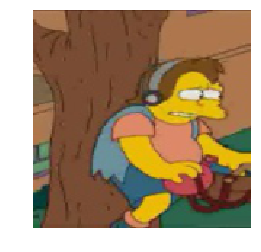

In [103]:
#prediction
idx = int(random.uniform(0, len(y_val)))
    
image_sample = x_val[idx]
label_sample = y_val[idx]
prediction = sess.run(logits, {X:[image_sample], y:[label_sample]})

prediction = lb.inverse_transform(prediction)

#showing
#image = images[idx]
lbl = np.array([label_sample])
lbl = lb.inverse_transform(lbl)
print("Label:{}".format(lbl))
print("Prediction: {}".format(prediction))

plt.imshow(image_sample)
plt.axis('off')
plt.show()